# Software Vulnerability Detection using Deep Learning (Experiment Replication)

### Multicolumn experiment (All CWEs and others)

* This is from Russell et. al work (Automated Vulnerability Detection in Source Code Using Deep Representation Learning) https://arxiv.org/abs/1807.04320
* Datasets downloaded from https://osf.io/d45bw/
* Datasets distribution: Training (80%), Validation (10%), Testing (10%)
* The dataset consists of the source code of 1.27 million functions mined from open source software, labeled by static analysis for potential vulnerabilities.
* Each function's raw source code, starting from the function name, is stored as a variable-length UTF-8 string. Five binary 'vulnerability' labels are provided for each function, corresponding to the four most common CWEs in our data plus all others: 
 * CWE-120 (3.7% of functions)
 * CWE-119 (1.9% of functions)
 * CWE-469 (0.95% of functions)
 * CWE-476 (0.21% of functions)
 * CWE-other (2.7% of functions)
* Functions may have more than one detected CWE each.
* Python 3.6 and Tensorflow 2.0.0

## Pre-processing

Using CVE-fixes database 

Import libs

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as lite
from sqlite3 import Error
from pathlib import Path
from datetime import date
import numpy as np
import seaborn as sns
import matplotlib.ticker as tick
import requests
import difflib as diff
import re 
import csv
import ast
%matplotlib inline

Create connection to database

In [4]:
def create_connection(db_file):
    """
    create a connection to sqlite3 database
    """
    conn = None
    try:
        conn = lite.connect(db_file, timeout=10)  # connection via sqlite3
        # engine = sa.create_engine('sqlite:///' + db_file)  # connection via sqlalchemy
        # conn = engine.connect()
    except Error as e:
        print(e)
    return conn
DATA_PATH = Path.cwd().parents[0] / 'Data'
FIGURE_PATH = Path.cwd() / 'figures'
RESULT_PATH = Path.cwd() / 'results'

Path(DATA_PATH).mkdir(parents=True, exist_ok=True)
Path(FIGURE_PATH).mkdir(parents=True, exist_ok=True)
Path(RESULT_PATH).mkdir(parents=True, exist_ok=True)

conn = create_connection("CVEfixes.db")

Get code and CWE from JavaScript

In [6]:
query = pd.read_sql_query("SELECT m.code, \
 cwe.cwe_id FROM method_change m, file_change f, commits cm, fixes, cve, cwe_classification cwe \
WHERE f.file_change_id=m.file_change_id AND cm.hash=f.hash AND cm.hash=fixes.hash AND fixes.cve_id=cve.cve_id AND cve.cve_id=cwe.cve_id AND f.programming_language='JavaScript'", conn)
query.to_pickle('methods.pickle')
print(query)

                                                    code  cwe_id
0      \t_setOption: function( key, value ) {\n\t\tva...  CWE-79
1      \t_setOption: function( key, value ) {\n\t\tva...  CWE-79
2      \t_title: function( title ) {\n\t\tif ( !this....  CWE-79
3      \t\tcontent: function() {\n\t\t\treturn $( thi...  CWE-79
4      \t\tcontent: function() {\n\t\t\tvar title = $...  CWE-79
...                                                  ...     ...
14245      AnsiUp.prototype.transform_to_html = funct...  CWE-79
14246      AnsiUp.prototype.transform_to_html = funct...  CWE-79
14247      function AnsiUp() {\n        this.VERSION ...  CWE-79
14248      function AnsiUp() {\n        this.VERSION ...  CWE-79
14249  function minify(req, res, next)\n{\n  var file...  CWE-22

[14250 rows x 2 columns]


Query to get the top CWE


In [9]:
get_top_cwe = pd.read_sql_query("SELECT DISTINCT cwe.cwe_id, COUNT(*) as Number FROM method_change m, file_change f, commits cm, fixes, cve, cwe_classification cwe WHERE f.file_change_id=m.file_change_id AND cm.hash=f.hash AND cm.hash=fixes.hash AND fixes.cve_id=cve.cve_id AND cve.cve_id=cwe.cve_id AND f.programming_language='JavaScript' GROUP BY cwe.cwe_id ORDER BY COUNT(*) DESC",conn)
print(get_top_cwe)

            cwe_id  Number
0           CWE-89    6248
1           CWE-79    4716
2          CWE-352     854
3           CWE-74     652
4           CWE-94     366
5         CWE-1236     243
6           CWE-20     189
7           CWE-22     181
8   NVD-CWE-noinfo     135
9          CWE-400     113
10   NVD-CWE-Other      90
11          CWE-78      68
12          CWE-77      44
13         CWE-384      43
14         CWE-732      36
15         CWE-200      27
16         CWE-436      21
17         CWE-287      18
18         CWE-918      17
19         CWE-284      16
20          CWE-88      11
21         CWE-674      11
22         CWE-330      11
23         CWE-502      10
24         CWE-434      10
25         CWE-345       9
26         CWE-310       9
27         CWE-668       8
28         CWE-601       8
29         CWE-295       8
30          CWE-59       7
31         CWE-444       6
32         CWE-185       6
33         CWE-863       4
34         CWE-787       4
35         CWE-346       4
3

Creating dataframe consists of top 4 CWE, the rest is list as CWE-other

In [10]:
method = pd.read_pickle('methods.pickle')
cwe_array = method['cwe_id'].to_numpy()
# creating array to store all cwe
CWE_Other = np.full(14250,False)
CWE_89 = np.full(14250,False)
CWE_79 = np.full(14250,False)
CWE_352 = np.full(14250,False)
CWE_74 = np.full(14250,False)

# Processing 

for idx, val in enumerate(cwe_array):
    if (val == "CWE-89"):
        CWE_89[idx]= True
    elif (val == "CWE-79"):
        CWE_79[idx] = True
    elif (val == "CWE-352"):
        CWE_352[idx] = True
    elif (val == "CWE-74"):
        CWE_74[idx] = True
    else:
        CWE_Other[idx]= True
    

# Creating the full dataset
data = pd.read_pickle('methods.pickle')
data = data.drop('cwe_id',1)
data['CWE-89']= CWE_89 
data['CWE-79']= CWE_79
data['CWE-352']= CWE_352
data['CWE-74']= CWE_74
data['CWE-Other'] = CWE_Other

final_frame = data.copy()
final_frame.to_pickle("full_set.pickle")


/tmp/ipykernel_5584/2756229120.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop('cwe_id',1)


Check the train set

In [11]:
df = pd.read_pickle('full_set.pickle');
# distribute data for train, test, validate

# for training
df_train =df.iloc[0:11400:,0:]
df_train.to_pickle('train.pickle')

# for validating
df_validate= df.iloc[11400:12825,0:]
df_validate.to_pickle('validate.pickle')

# for testing
df_test = df.iloc[12825:14250,0:]
df_test.to_pickle('test.pickle')

In [19]:
mydf.to_pickle("VDISC_train.pickle")
#mydf.to_pickle("VDISC_validate.pickle")
#mydf.to_pickle("VDISC_test.pickle")

## Exploratory Data Analysis

### Importing processed datasets

In [12]:
train=pd.read_pickle("train.pickle")
validate=pd.read_pickle("validate.pickle")
test=pd.read_pickle("test.pickle")

In [4]:
### CONTINUE LATER

## Learning Phase

### Importing libraries

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import pickle

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

2021-12-29 03:23:14.718136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-29 03:23:14.718164: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorlfow version:  2.7.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


2021-12-29 03:23:16.494389: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-29 03:23:16.495403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-29 03:23:16.495423: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-29 03:23:16.495453: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-2): /proc/driver/nvidia/version does not exist


### Setting static and global variables

In [15]:
# Generate random seed
#myrand=np.random.randint(1, 99999 + 1)
myrand=71926
np.random.seed(myrand)
tf.random.set_seed(myrand)
print("Random seed is:",myrand)

Random seed is: 71926


In [16]:
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=10

### Importing processed datasets

In [17]:
train=pd.read_pickle("train.pickle")
validate=pd.read_pickle("validate.pickle")
test=pd.read_pickle("test.pickle")

for dataset in [train,validate,test]:
    for col in range(1,6):
        dataset.iloc[:,col] = dataset.iloc[:,col].map({False: 0, True: 1})

# Create source code sdata for tokenization
x_all = train['code']
#x_all = x_all.append(validate['functionSource'])
#x_all = x_all.append(test['functionSource'])

In [18]:
# Overview of the datasets
train.head()

,code,CWE-89,CWE-79,CWE-352,CWE-74,CWE-Other
0,"\t_setOption: function( key, value ) {\n\t\tva...",0,1,0,0,0
1,"\t_setOption: function( key, value ) {\n\t\tva...",0,1,0,0,0
2,\t_title: function( title ) {\n\t\tif ( !this....,0,1,0,0,0
3,\t\tcontent: function() {\n\t\t\treturn $( thi...,0,1,0,0,0
4,\t\tcontent: function() {\n\t\t\tvar title = $...,0,1,0,0,0


### Tokenizing the source codes

In [19]:
# Tokenizer with word-level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(x_all))
del(x_all)
print('Number of tokens: ',len(tokenizer.word_counts))

Number of tokens:  25446


In [20]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

In [21]:
# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

[('this', 5550343),
 ('t', 3020174),
 ('e', 2966786),
 ('a', 2119654),
 ('function', 1806102),
 ('i', 1727531),
 ('0', 1391282),
 ('n', 1236981),
 ('b', 1126133),
 ('s', 1058847)]

### Create sequence files from the tokens

In [22]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(train['code'])
x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

In [23]:
## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(test['code'])
x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

In [24]:
## Tokkenizing validate data and create matrix
list_tokenized_validate = tokenizer.texts_to_sequences(validate['code'])
x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_validate = x_validate.astype(np.int64)

In [25]:
# Example data
test.iloc[0:5,1:6]

,CWE-89,CWE-79,CWE-352,CWE-74,CWE-Other
12825,0,1,0,0,0
12826,0,1,0,0,0
12827,0,1,0,0,0
12828,0,1,0,0,0
12829,0,1,0,0,0


### One-Hot-Enconding (OHE) on the datasets

In [26]:
y_train=[]
y_test=[]
y_validate=[]

for col in range(1,6):
    y_train.append(tf.keras.utils.to_categorical(train.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_test.append(tf.keras.utils.to_categorical(test.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))
    y_validate.append(tf.keras.utils.to_categorical(validate.iloc[:,col], num_classes=NUM_CLASSES).astype(np.int64))

In [27]:
# Example data
y_test[0][1:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

### Model Definition (CNN with Gaussian Noise and 5 Output Splits)

In [28]:
# Create a random weights matrix

random_weights = np.random.normal(size=(WORDS_SIZE, 13),scale=0.01)

In [29]:
# Must use non-sequential model building to create branches in the output layer
inp_layer = tf.keras.layers.Input(shape=(INPUT_SIZE,))
mid_layers = tf.keras.layers.Embedding(input_dim = WORDS_SIZE,
                                    output_dim = 13,
                                    weights=[random_weights],
                                    input_length = INPUT_SIZE)(inp_layer)
mid_layers = tf.keras.layers.Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu')(mid_layers)
mid_layers = tf.keras.layers.MaxPool1D(pool_size=5)(mid_layers)
mid_layers = tf.keras.layers.Dropout(0.5)(mid_layers)
mid_layers = tf.keras.layers.Flatten()(mid_layers)
mid_layers = tf.keras.layers.Dense(64, activation='relu')(mid_layers)
mid_layers = tf.keras.layers.Dense(16, activation='relu')(mid_layers)
output1 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output2 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output3 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output4 =tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
output5 = tf.keras.layers.Dense(2, activation='softmax')(mid_layers)
model = tf.keras.Model(inp_layer,[output1,output2,output3,output4,output5])

# Define custom optimizers
adam = tf.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print("CNN model built: ")
model.summary()

CNN model built: 
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 13)      130000      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 500, 512)     60416       ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 100, 512)     0           ['conv1d[0][0]']                 
                                                                            

/home/huydnevermore/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Tensorboard Callbacks

In [30]:
## Create TensorBoard callbacks

callbackdir= '/home/huydnevermore/Desktop/tf'

tbCallback = tf.keras.callbacks.TensorBoard(log_dir=callbackdir, 
                         histogram_freq=1,
                         embeddings_freq=1,
                         write_graph=True, 
                         write_images=True)

tbCallback.set_model(model)
mld = 'model/model-ALL-{epoch:02d}.hdf5'

## Create best model callback
mcp = tf.keras.callbacks.ModelCheckpoint(filepath=mld, 
                                         monitor="val_loss",
                                         save_best_only=True, 
                                         mode='auto', 
                                         save_freq='epoch', 
                                         verbose=1)

### Model Training

In [31]:
class_weights = [{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.},{0: 1., 1: 5.}]

history = model.fit(x = x_train,
          y = [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
          validation_data = (x_validate, [y_validate[0], y_validate[1], y_validate[2], y_validate[3], y_validate[4]]),
          epochs = 40,
          batch_size = 128,
          callbacks=[mcp,tbCallback])

with open('history/History-ALL-40EP-CNN', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

2021-12-29 03:30:19.715551: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 45600000 exceeds 10% of free system memory.


Epoch 1/40


2021-12-29 03:30:23.696689: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 131072000 exceeds 10% of free system memory.
2021-12-29 03:30:23.849845: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 52428800 exceeds 10% of free system memory.
2021-12-29 03:30:23.849920: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 131072000 exceeds 10% of free system memory.


 1/90 [..............................] - ETA: 2:29 - loss: 3.4658 - dense_2_loss: 0.6933 - dense_3_loss: 0.6939 - dense_4_loss: 0.6933 - dense_5_loss: 0.6915 - dense_6_loss: 0.6937 - dense_2_accuracy: 0.4219 - dense_3_accuracy: 0.3281 - dense_4_accuracy: 0.3906 - dense_5_accuracy: 0.7969 - dense_6_accuracy: 0.2578

2021-12-29 03:30:24.071927: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 131072000 exceeds 10% of free system memory.


89/90 [============================>.] - ETA: 0s - loss: 3.3415 - dense_2_loss: 0.6900 - dense_3_loss: 0.6832 - dense_4_loss: 0.6512 - dense_5_loss: 0.6248 - dense_6_loss: 0.6923 - dense_2_accuracy: 0.5323 - dense_3_accuracy: 0.6742 - dense_4_accuracy: 0.8986 - dense_5_accuracy: 0.9873 - dense_6_accuracy: 0.6711
Epoch 00001: val_loss improved from inf to 3.36789, saving model to model/model-ALL-01.hdf5
90/90 [==============================] - 26s 269ms/step - loss: 3.3414 - dense_2_loss: 0.6900 - dense_3_loss: 0.6831 - dense_4_loss: 0.6512 - dense_5_loss: 0.6248 - dense_6_loss: 0.6923 - dense_2_accuracy: 0.5325 - dense_3_accuracy: 0.6743 - dense_4_accuracy: 0.8986 - dense_5_accuracy: 0.9873 - dense_6_accuracy: 0.6712 - val_loss: 3.3679 - val_dense_2_loss: 0.7901 - val_dense_3_loss: 0.6389 - val_dense_4_loss: 0.5653 - val_dense_5_loss: 0.6805 - val_dense_6_loss: 0.6929 - val_dense_2_accuracy: 0.0014 - val_dense_3_accuracy: 0.9509 - val_dense_4_accuracy: 1.0000 - val_dense_5_accuracy: 0.

### Model Evaluation using Testing Set

In [32]:
# Load model
model = tf.keras.models.load_model("model/model-ALL-01.hdf5")

In [33]:
results = model.evaluate(x_test, y_test, batch_size=128)
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

12/12 [==============================] - 1s 67ms/step - loss: 3.3192 - dense_2_loss: 0.8027 - dense_3_loss: 0.7577 - dense_4_loss: 0.5557 - dense_5_loss: 0.5122 - dense_6_loss: 0.6910 - dense_2_accuracy: 0.0000e+00 - dense_3_accuracy: 0.0204 - dense_4_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_6_accuracy: 0.9796
loss: 3.319195032119751
dense_2_loss: 0.8026708960533142
dense_3_loss: 0.7576974630355835
dense_4_loss: 0.555677592754364
dense_5_loss: 0.5121943950653076
dense_6_loss: 0.6909546852111816
dense_2_accuracy: 0.0
dense_3_accuracy: 0.020350877195596695
dense_4_accuracy: 1.0
dense_5_accuracy: 1.0
dense_6_accuracy: 0.9796491265296936


### Check The Evaluation Metrics

In [34]:
predicted = model.predict(x_test)

In [35]:
pred_test = [[],[],[],[],[]]

for col in range(0,len(predicted)):
    for row in predicted[col]:
        if row[0] >= row[1]:
            pred_test[col].append(0)
        else:
            pred_test[col].append(1)
            
for col in range(0,len(predicted)):
    print(pd.value_counts(pred_test[col]))

1    1425
dtype: int64
0    1425
dtype: int64
0    1425
dtype: int64
0    1425
dtype: int64
0    1425
dtype: int64


### Evaluate on the testing set

In [36]:

for col in range(1,6):
    print('\nThis is evaluation for column',col)
    confusion = sklearn.metrics.confusion_matrix(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])
    print(confusion)
    tn, fp, fn, tp = confusion.ravel()
    print('\nTP:',tp)
    print('FP:',fp)
    print('TN:',tn)
    print('FN:',fn)

    ## Performance measure
    print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Precision: '+ str(sklearn.metrics.precision_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Recall: '+ str(sklearn.metrics.recall_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))
    print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=test.iloc[:,col].to_numpy(), y_score=predicted[col-1][:,1])))
    print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=test.iloc[:,col].to_numpy(), y_score=predicted[col-1][:,1])))
    print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=test.iloc[:,col].to_numpy(), y_pred=pred_test[col-1])))


This is evaluation for column 1
[[   0 1425]
 [   0    0]]

TP: 0
FP: 1425
TN: 0
FN: 0

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F-measure: 0.0
Precision-Recall AUC: nan


/home/huydnevermore/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/huydnevermore/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

### Plot The Model's Training History

/tmp/ipykernel_5584/2513436125.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[6])], 'b', label='CWE-89', color='green')
/tmp/ipykernel_5584/2513436125.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[7])], 'b', label='CWE-79', color='blue')
/tmp/ipykernel_5584/2513436125.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[8])], 'b', label='CWE-352', color='red')
/tmp/ipykernel_5584/2513

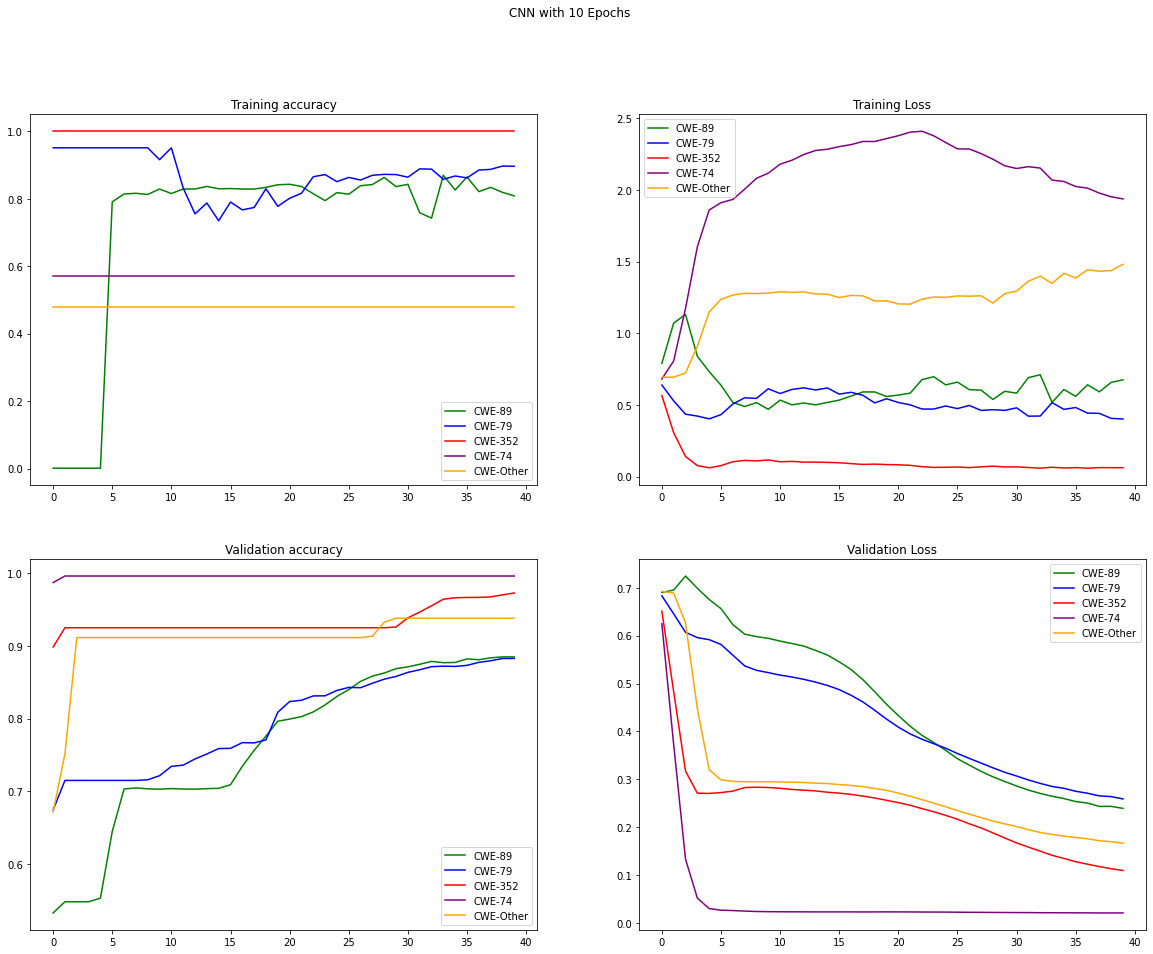

In [38]:
epochs_range = range(len(history.history[model.metrics_names[1]]))

fig, axs = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('CNN with 10 Epochs')

axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[6])], 'b', label='CWE-89', color='green')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[7])], 'b', label='CWE-79', color='blue')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[8])], 'b', label='CWE-352', color='red')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[9])], 'b', label='CWE-74SS', color='purple')
axs[0,0].plot(epochs_range, history.history['val_%s'%(model.metrics_names[10])], 'b', label='CWE-Other', color='orange')
axs[0,0].set_title('Training accuracy')
axs[0,0].legend()


axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[1])], 'b', label='CWE-89', color='green')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[2])], 'b', label='CWE-79', color='blue')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[3])], 'b', label='CWE-352', color='red')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[4])], 'b', label='CWE-74SS', color='purple')
axs[0,1].plot(epochs_range, history.history['val_%s'%(model.metrics_names[5])], 'b', label='CWE-Other', color='orange')
axs[0,1].set_title('Training Loss')
axs[0,1].legend()

axs[1,0].plot(epochs_range, history.history[model.metrics_names[6]], 'b', label='CWE-89', color='green')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[7]], 'b', label='CWE-79', color='blue')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[8]], 'b', label='CWE-352', color='red')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[9]], 'b', label='CWE-74SS', color='purple')
axs[1,0].plot(epochs_range, history.history[model.metrics_names[10]], 'b', label='CWE-Other', color='orange')
axs[1,0].set_title('Validation accuracy')
axs[1,0].legend()


axs[1,1].plot(epochs_range, history.history[model.metrics_names[1]], 'b', label='CWE-89', color='green')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[2]], 'b', label='CWE-79', color='blue')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[3]], 'b', label='CWE-352', color='red')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[4]], 'b', label='CWE-74SS', color='purple')
axs[1,1].plot(epochs_range, history.history[model.metrics_names[5]], 'b', label='CWE-Other', color='orange')
axs[1,1].set_title('Validation Loss')
axs[1,1].legend()

